In [108]:
import os, sys, time

import numpy as np
import scipy as sp
import pandas as pd
import skimage.io

import sklearn
import sklearn.ensemble
import sklearn.decomposition
import sklearn.manifold
import sklearn.discriminant_analysis

import dask
import dask.distributed
import dask.diagnostics

from IPython.display import display
import ipywidgets

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import large_image

import histomicstk as htk
import histomicstk.preprocessing.color_conversion as htk_ccvt
import histomicstk.preprocessing.color_normalization as htk_cnorm
import histomicstk.preprocessing.color_deconvolution as htk_cdeconv
import histomicstk.filters.shape as htk_shape_filters
import histomicstk.segmentation as htk_seg
import histomicstk.features as htk_features

import hpsklearn, hyperopt

import tda_utils
import cell_graph_features as cgf

%load_ext autoreload
%autoreload 2
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = True
plt.gray()

labelsize = 30

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
scheduler = 'localhost:8786'
c = dask.distributed.Client(scheduler)
print c

<Client: scheduler='tcp://localhost:8786' processes=15 cores=15>


### Explore and munge dataset

In [3]:
dataDir = '/home/deepak.chittajallu/emory/data/glas_data'

In [4]:
def strip_whitespace( x ):
    if isinstance( x, basestring ):
        return x.strip()
    else:
        return x

def get_binary_grade(row):
    
    if row['diagnosis'] == 'benign':
        return 'normal'
    elif row['grade'] == 'poorly differentiated':
        return 'high-grade'
    else:
        return 'low-grade'
    
def print_dataset_summary(df):
    
    diag_freq = dict(df['diagnosis'].value_counts(normalize=True))
    for k,v in diag_freq.items():
        print '\t%s - %d (%.2f%%)' % (k, v * len(df), 100 * v)
        
    grade_freq = dict(df['grade'].value_counts(normalize=True))
    print '\n',
    for k,v in grade_freq.items():
        print '\t%s - %d (%.2f%%)' % (k, v * len(df), 100 * v)    
        
    bingrade_freq = dict(df['binarized_grade'].value_counts(normalize=True))
    print '\n',
    for k,v in bingrade_freq.items():
        print '\t%s - %d (%.2f%%)' % (k, v * len(df), 100 * v)
        
    print '\n\tTotal - %d' % len(df)
        
def display_dataset(df, func=None, figsize=(15, 15)):

    grade_list = df.grade.unique().tolist()
    grade_counts = df['grade'].value_counts()
    
    grade_widget = ipywidgets.Dropdown(options=grade_list, value='healthy')
    index_widget = ipywidgets.IntSlider(min=0, max=grade_counts[grade_list[0]])
    
    def handle_grade_change(change): 
       
        index_widget.value = 0
        index_widget.max = grade_counts[change.new]
        
    grade_widget.observe(handle_grade_change, names='value')
    
    def browse_images(grade, index):        

        df_grade = df[df.apply(lambda x: x['grade'] == grade, axis=1)]
        
        row = df_grade.iloc[min(index, len(df_grade)-1)]
        fname = os.path.join(dataDir, row['name'] + '.bmp')        
        im_input = skimage.io.imread(fname)[:, :, :3]
        
        print 'filename = ', row['name'] + '.bmp'
        
        if func is None:            
            fname_annot = os.path.join(dataDir, 'annot', row['name'] + '_anno.bmp') 
            im_input_annot = skimage.io.imread(fname_annot)
        
            plt.figure(figsize=figsize)
            
            plt.subplot(1, 2, 1)
            plt.imshow(im_input)
            plt.title(row['diagnosis'] + ' - ' + row['binarized_grade'] + ' - ' + row['grade'])
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(skimage.segmentation.mark_boundaries(im_input, im_input_annot, mode='thick'))
            plt.title('Gland segmentation ground truth')
            plt.axis('off')
            
        else:
            ret = func(im_input, display_result=True)

        plt.show()
            
    ipywidgets.interact(browse_images, grade=grade_widget, index=index_widget)      

In [5]:
df = pd.read_csv(os.path.join(dataDir, 'Grade.csv'))
df = df.applymap(strip_whitespace)

df.columns = ['name', 'pid', 'diagnosis', 'grade']
df['binarized_grade'] = df.apply(lambda row: get_binary_grade(row), axis=1)

display(df.iloc[np.random.randint(0, len(df), 20), :])

print '\nTotal dataset summary:'
print_dataset_summary(df)

name  pid  diagnosis                               grade  \
121  train_47    5     benign                         adenomatous   
26   testA_33    9     benign                             healthy   
14   testA_22   11  malignant  moderately-to-poorly differentated   
25   testA_32   11  malignant  moderately-to-poorly differentated   
36   testA_42    7  malignant           moderately differentiated   
149  train_72   10     benign                             healthy   
157  train_08   10     benign                             healthy   
117  train_43    2  malignant  moderately-to-poorly differentated   
1    testA_10   10     benign                             healthy   
85   train_14    1  malignant  moderately-to-poorly differentated   
4    testA_13    7  malignant           moderately differentiated   
91   train_02    5     benign                         adenomatous   
70   testB_19    2  malignant  moderately-to-poorly differentated   
65   testB_14    3  malignant           moderately differentiated   
84   train_13    1  malignant               poorly differentiated   
11   testA_02    3     benign                             healthy   
11   testA_02    3     benign                             healthy   
68   testB_17    5     benign                         adenomatous   
148  train_71    2  malignant           moderately differentiated   
42   testA_48    4  malignant               poorly differentiated   

    binarized_grade  
121          normal  
26           normal  
14        low-grade  
25        low-grade  
36        low-grade  
149          normal  
157          normal  
117       low-grade  
1            normal  
85        low-grade  
4         low-grade  
91           normal  
70        low-grade  
65        low-grade  
84       high-grade  
11           normal  
11           normal  
68           normal  
148       low-grade  
42       high-grade


Total dataset summary:
	benign - 74 (44.85%)
	malignant - 91 (55.15%)

	healthy - 41 (25.45%)
	adenomatous - 32 (19.39%)
	moderately-to-poorly differentated - 20 (12.12%)
	poorly differentiated - 24 (14.55%)
	moderately differentiated - 47 (28.48%)

	high-grade - 24 (14.55%)
	low-grade - 67 (40.61%)
	normal - 74 (44.85%)

	Total - 165


In [6]:
df_test = df[df.apply(lambda x: x['name'].startswith('test'), axis=1)]

print '\nTest set summary: '
print_dataset_summary(df_test)


Test set summary: 
	benign - 37 (46.25%)
	malignant - 43 (53.75%)

	healthy - 21 (26.25%)
	adenomatous - 16 (20.00%)
	moderately-to-poorly differentated - 8 (10.00%)
	poorly differentiated - 12 (15.00%)
	moderately differentiated - 23 (28.75%)

	high-grade - 12 (15.00%)
	low-grade - 31 (38.75%)
	normal - 37 (46.25%)

	Total - 80


In [7]:
df_train = df[df.apply(lambda x: x['name'].startswith('train'), axis=1)]

print '\nTraining set summary:'
print_dataset_summary(df_train)


Training set summary:
	benign - 37 (43.53%)
	malignant - 48 (56.47%)

	healthy - 21 (24.71%)
	adenomatous - 16 (18.82%)
	moderately-to-poorly differentated - 12 (14.12%)
	poorly differentiated - 12 (14.12%)
	moderately differentiated - 24 (28.24%)

	high-grade - 12 (14.12%)
	low-grade - 36 (42.35%)
	normal - 37 (43.53%)

	Total - 85


In [8]:
display_dataset(df_train, figsize=(16, 8))

A Jupyter Widget

### Tune nuclei detection

In [9]:
def detect_nuclei(im_input, min_radius=6, max_radius=10, display_result=False):
    
    # color normalization
    ref_mu_lab=(8.63234435, -0.11501964, 0.03868433)
    ref_std_lab=(0.57506023, 0.10403329, 0.01364062)
    
    im_nmzd = htk_cnorm.reinhard(im_input, ref_mu_lab, ref_std_lab)
    
    # color deconvolution
    w_est = htk_cdeconv.rgb_separate_stains_macenko_pca(im_nmzd, 255)
    nuclear_chid = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map['hematoxylin'], w_est)
    im_nuclei_stain = htk_cdeconv.color_deconvolution(im_nmzd, w_est, 255).Stains[:, :, nuclear_chid]
    
    # segment nuclei foreground
    th = skimage.filters.threshold_li(im_nuclei_stain) * 0.8
    # th = skimage.filters.threshold_otsu(im_nuclei_stain)
    im_fgnd_mask = im_nuclei_stain < th
    im_fgnd_mask = skimage.morphology.opening(im_fgnd_mask, skimage.morphology.disk(2))
    im_fgnd_mask = skimage.morphology.closing(im_fgnd_mask, skimage.morphology.disk(1))
    
    # detect nuclei
    im_dog, im_dog_sigma = htk_shape_filters.cdog(im_nuclei_stain, im_fgnd_mask, 
                                                  sigma_min=min_radius / np.sqrt(2),
                                                  sigma_max=max_radius / np.sqrt(2))

    nuclei_coord = skimage.feature.peak_local_max(im_dog, min_distance=min_radius/2, threshold_rel=0.1)
    
    nuclei_coord = nuclei_coord[im_fgnd_mask[nuclei_coord[:, 0], nuclei_coord[:, 1]], :]
    
    nuclei_rad = np.array([im_dog_sigma[nuclei_coord[i, 0], nuclei_coord[i, 1]] * np.sqrt(2) 
                           for i in range(nuclei_coord.shape[0])])
    
    # display result
    if display_result:
        
        print 'Number of nuclei = ', nuclei_coord.shape[0]
    
        plt.figure(figsize=(30,20))
        plt.subplot(2, 2, 1)
        plt.imshow(im_input)
        plt.title('Input', fontsize=labelsize)
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(im_nuclei_stain)
        plt.title('Deconv nuclei stain', fontsize=labelsize)
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(im_fgnd_mask)
        plt.title('Foreground mask', fontsize=labelsize)
        plt.axis('off')

        plt.subplot(2, 2, 4)        
        plt.imshow(im_nmzd)  
        plt.plot(nuclei_coord[:, 1], nuclei_coord[:, 0], 'k+')

        for i in range(nuclei_coord.shape[0]):

            cx = nuclei_coord[i, 1]
            cy = nuclei_coord[i, 0]
            r = nuclei_rad[i]

            mcircle = mpatches.Circle((cx, cy), r, color='g', fill=False)
            plt.gca().add_patch(mcircle)

        plt.title('Nuclei detection', fontsize=labelsize)
        plt.axis('off')

        plt.tight_layout()
        
    return nuclei_coord, nuclei_rad

In [10]:
display_dataset(df_train, func=detect_nuclei)

A Jupyter Widget

### Tune generation of persistence diagram

In [11]:
import tda_utils

In [12]:
def compute_nuclei_persistence_diagram(im_input, inf_val=175, nuclei_pts=None, display_result=False):

    # Detect nuclei centroids
    if nuclei_pts is None:

        tic = time.time()
        nuclei_pts, nuclei_rad = detect_nuclei(im_input, display_result=False)
        toc = time.time()
        print 'Nuclei detection: %d nuclei, %.2f seconds' % (len(nuclei_rad), (toc - tic))
    
    # Compute persistence diagram
    tic = time.time()
    
    dgm_mph = np.asarray(tda_utils.ComputeDiagramMPH(nuclei_pts, 1))
    bd_pairs_mph = [dgm_mph[dgm_mph[:, 0] == i, 1:] for i in range(2)]
    
    toc = time.time()
    print 'Persistence diagram computation: Dim0 - %d points, Dim1 - %d points, %.2f seconds' % (
        bd_pairs_mph[0].shape[0], bd_pairs_mph[1].shape[0], (toc - tic))
    
    # display result
    if display_result:
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(im_input)
        plt.title('Input')
        plt.axis('off')

        plt.subplot(1, 2, 2)        
        plt.imshow(im_input)  
        plt.plot(nuclei_pts[:, 1], nuclei_pts[:, 0], 'g+')

        plt.title('Nuclei detection')
        plt.axis('off')
        
        plt.figure(figsize=(14, 7))
        for i in range(2):

            plt.subplot(1, 2, i+1)
            tda_utils.plot_persistence_diagram(bd_pairs_mph[i], inf_val=inf_val)
            plt.title('Persistence diagram (dim=%d, #points=%d)' % (i, bd_pairs_mph[i].shape[0]))

        plt.tight_layout()
        
    return bd_pairs_mph, dgm_mph

In [13]:
display_dataset(df_train, compute_nuclei_persistence_diagram)

A Jupyter Widget

### Tune generation of persistence image

In [14]:
def compute_nuclei_persistence_image(im_input, out_res=30, max_dist=175, sigma_factor=3, 
                                     nuclei_pts=None, display_result=False):

    # Detect nuclei centroids
    if nuclei_pts is None:

        tic = time.time()
        nuclei_pts, nuclei_rad = detect_nuclei(im_input, display_result=False)  
        toc = time.time()
        print 'Nuclei detection: %d nuclei, %.2f seconds' % (len(nuclei_rad), (toc - tic))
         
    # compute nuclei persistence diagram
    bd_pairs_mph, dgm_mph = compute_nuclei_persistence_diagram(im_input, inf_val=max_dist, 
                                                               nuclei_pts=nuclei_pts)

    # Compute persistence image
    sigma = sigma_factor * max_dist / out_res
    
    tic = time.time()
    
    im_pi_dim_0 = tda_utils.compute_persistence_image(bd_pairs_mph[0], out_res, max_dist, max_dist, sigma=sigma)
    im_pi_dim_1 = tda_utils.compute_persistence_image(bd_pairs_mph[1], out_res, max_dist, max_dist, sigma=sigma)
    
    toc = time.time()
    
    print 'Persistence image computation: %.2f seconds' % (toc - tic)
        
    # display result
    if display_result:
    
        plt.figure(figsize=(16, 8))
                                               
        plt.subplot(1, 2, 1)
        plt.imshow(im_input)
        plt.title('Input')
        plt.axis('off')
        plt.subplot(1, 2, 2)        
        plt.imshow(im_input)  
        plt.plot(nuclei_pts[:, 1], nuclei_pts[:, 0], 'g+')

        plt.title('Nuclei detection')
        plt.axis('off')
                                            
        plt.figure(figsize=(16, 8))
        for i in range(2):

            plt.subplot(1, 2, i+1)
            tda_utils.plot_birth_persistence_diagram(bd_pairs_mph[i], inf_val=max_dist)
            plt.title('Birth-persistence diagram (dim=%d, #points=%d)' % (i, bd_pairs_mph[i].shape[0]))

        plt.figure(figsize=(16, 8))
        
        plt.subplot(1, 2, 1)
        x_vals = np.linspace(0, max_dist, out_res+1)[:-1]
        plt.plot(x_vals, im_pi_dim_0)
        plt.xlabel('Birth')
        plt.ylabel('Persistence')        

        plt.subplot(1, 2, 2)
        plt.imshow(im_pi_dim_1, cmap=plt.cm.hot, origin='lower', extent=[0, max_dist, 0, max_dist])
        plt.xlabel('Birth')
        plt.ylabel('Persistence')

        plt.tight_layout()

    return im_pi_dim_0, im_pi_dim_1

In [15]:
display_dataset(df_train, compute_nuclei_persistence_image)

A Jupyter Widget

### Tune generation of persistence landscape

In [16]:
def compute_nuclei_persistence_landscape(im_input, k=30, num_scale_samples=30, max_dist=175, 
                                         nuclei_pts=None, display_result=False):

    # Detect nuclei centroids
    if nuclei_pts is None:

        tic = time.time()
        nuclei_pts, nuclei_rad = detect_nuclei(im_input, display_result=False)  
        toc = time.time()
        print 'Nuclei detection: %d nuclei, %.2f seconds' % (len(nuclei_rad), (toc - tic))
         
    # compute nuclei persistence diagram
    bd_pairs_mph, dgm_mph = compute_nuclei_persistence_diagram(im_input, inf_val=max_dist, 
                                                               nuclei_pts=nuclei_pts)

    # Compute persistence landscape
    tic = time.time()
    
    scale_range = np.array([0, max_dist])
    lscape_dim_0, scale_seq = tda_utils.compute_persistence_landscape(dgm_mph, 0, 
                                                                      k=k, samples=num_scale_samples, 
                                                                      scale_range=scale_range)

    lscape_dim_1, scale_seq = tda_utils.compute_persistence_landscape(dgm_mph, 1, 
                                                                      k=k, samples=num_scale_samples, 
                                                                      scale_range=scale_range)
    
    toc = time.time()
    
    print 'Persistence landscape computation: %.2f seconds' % (toc - tic)
        
    # display result
    if display_result:
    
        plt.figure(figsize=(16, 8))
                                               
        plt.subplot(1, 2, 1)
        plt.imshow(im_input)
        plt.title('Input')
        plt.axis('off')
        plt.subplot(1, 2, 2)        
        plt.imshow(im_input)  
        plt.plot(nuclei_pts[:, 1], nuclei_pts[:, 0], 'g+')

        plt.title('Nuclei detection')
        plt.axis('off')
                                            
        plt.figure(figsize=(16, 8))
        for i in range(2):

            plt.subplot(1, 2, i+1)
            tda_utils.plot_birth_persistence_diagram(bd_pairs_mph[i], inf_val=max_dist)
            plt.title('Birth-persistence diagram (dim=%d, #points=%d)' % (i, bd_pairs_mph[i].shape[0]))

        plt.figure(figsize=(12, 8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(lscape_dim_0, cmap=plt.cm.hot) 
        plt.ylabel('k')
        plt.xlabel('scale')
        
        plt.subplot(1, 2, 2)
        plt.imshow(lscape_dim_1, cmap=plt.cm.hot) 
        plt.ylabel('k')
        plt.xlabel('scale')
        
        plt.tight_layout()

    return lscape_dim_0, lscape_dim_1

In [17]:
display_dataset(df_train, compute_nuclei_persistence_landscape)

A Jupyter Widget

### Augment training data

In [18]:
import imgaug

seq = imgaug.augmenters.Sequential([
    imgaug.augmenters.Crop(percent=0.03),
    imgaug.augmenters.Affine(translate_percent=0.03, rotate=(-10, 10), cval=255)
])

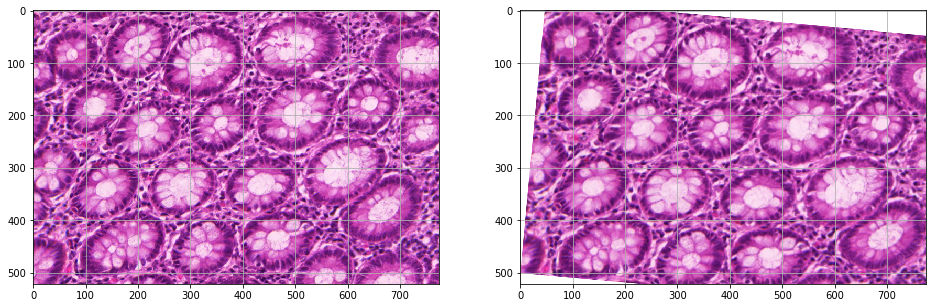

In [19]:
fname = os.path.join(dataDir, 'train_22.bmp')        
im_input = skimage.io.imread(fname)[:, :, :3]
        
im_input_aug = seq.augment_image(im_input)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(im_input)

plt.subplot(1, 2, 2)
plt.imshow(im_input_aug)

### Generate figure for paper

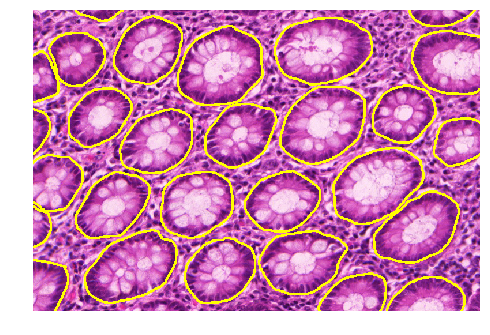

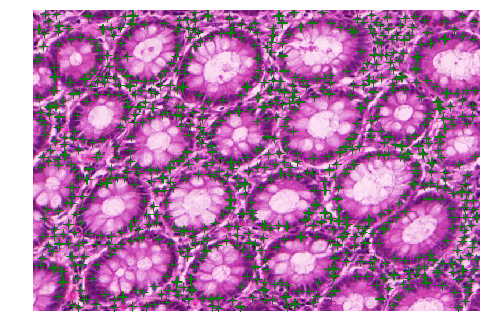

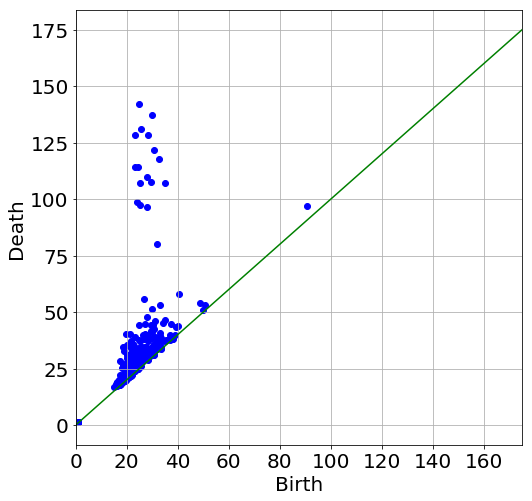

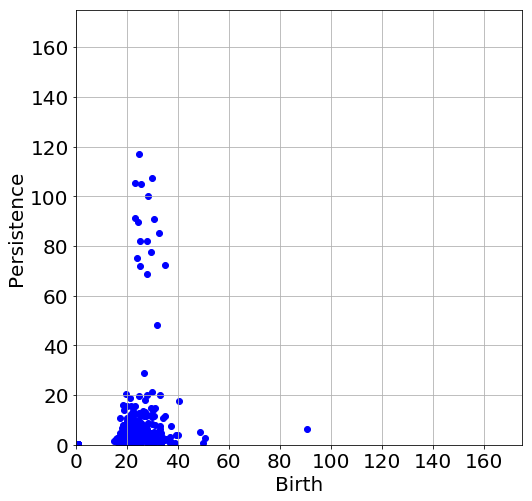

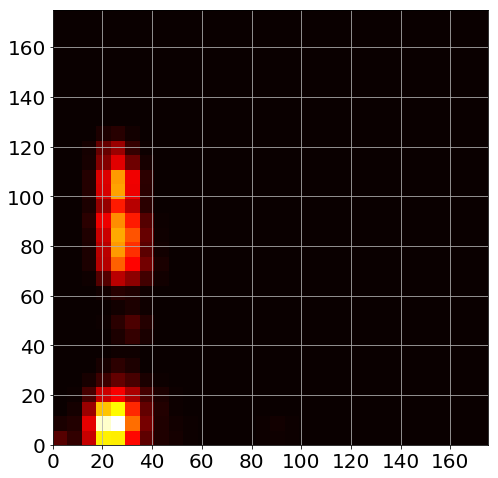

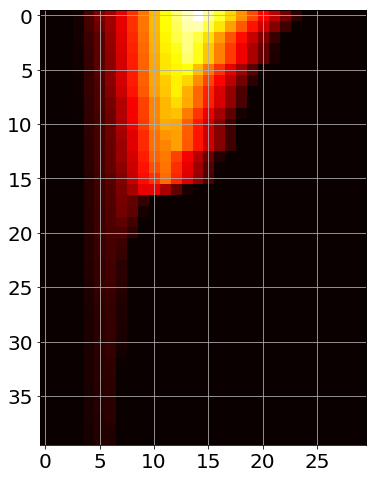

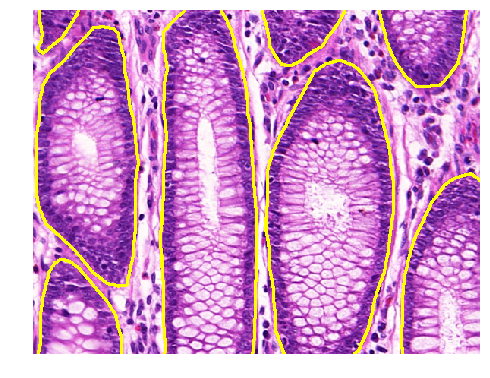

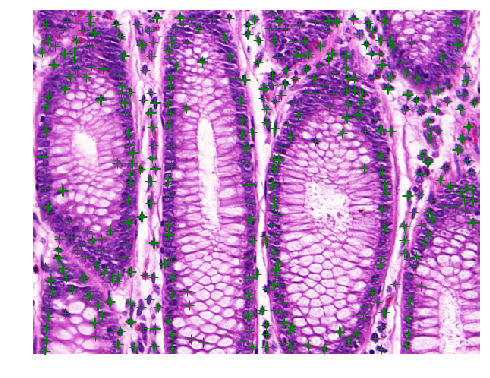

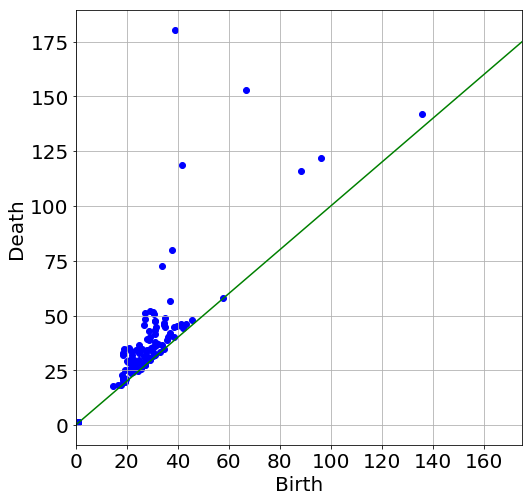

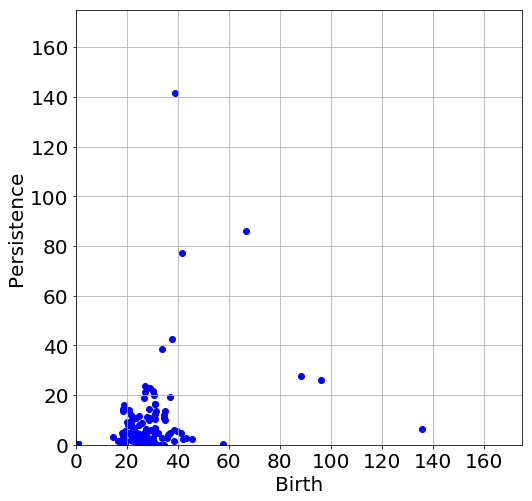

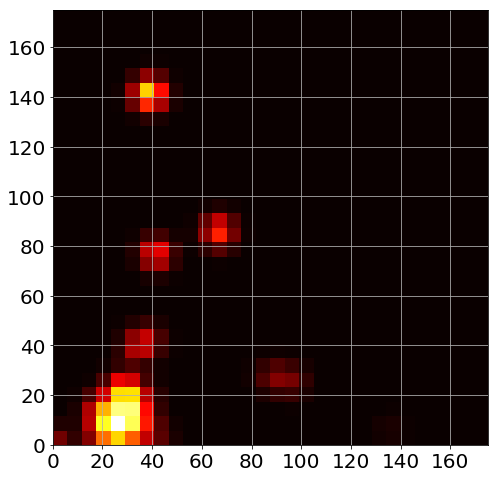

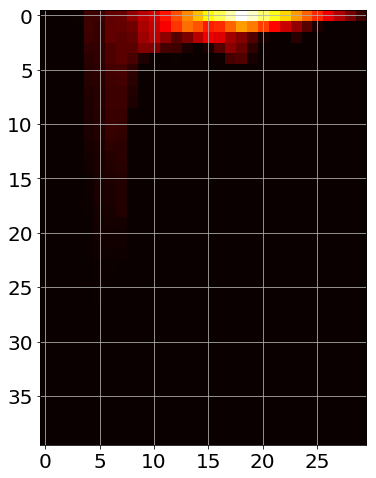

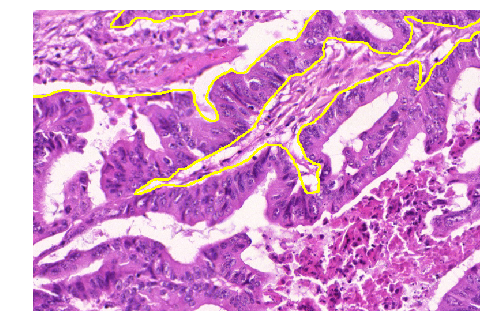

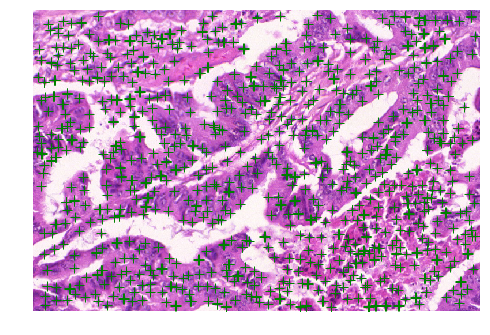

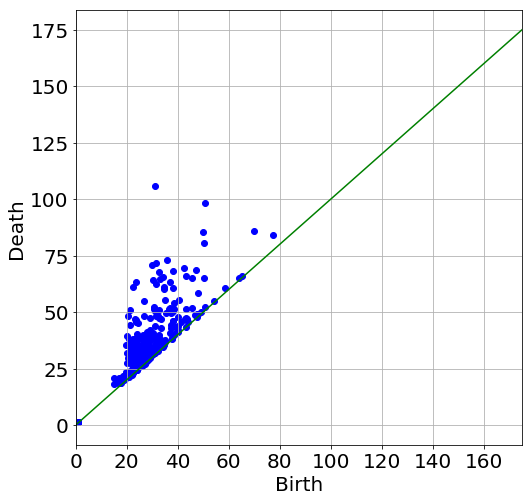

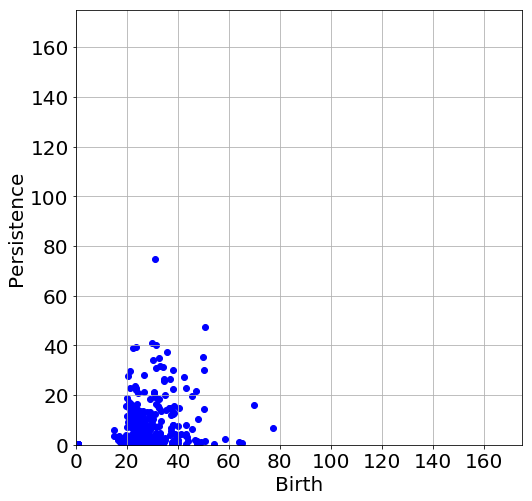

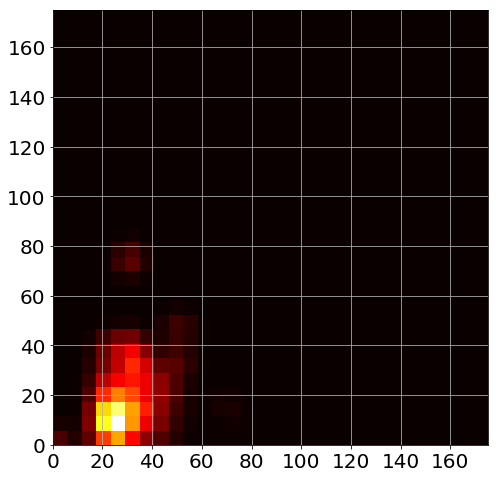

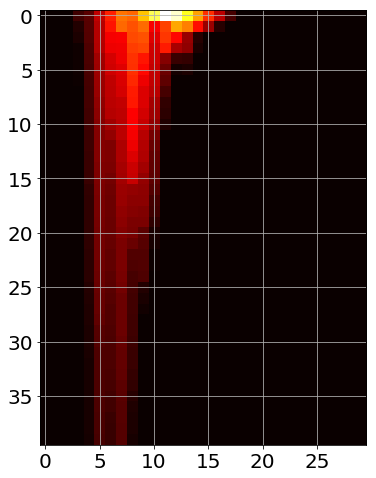

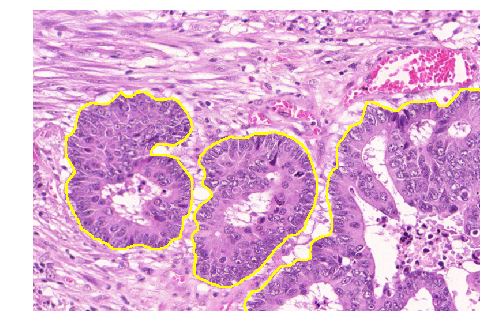

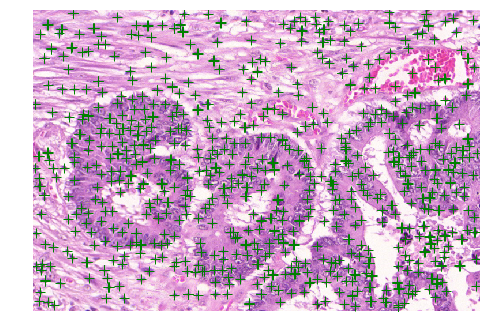

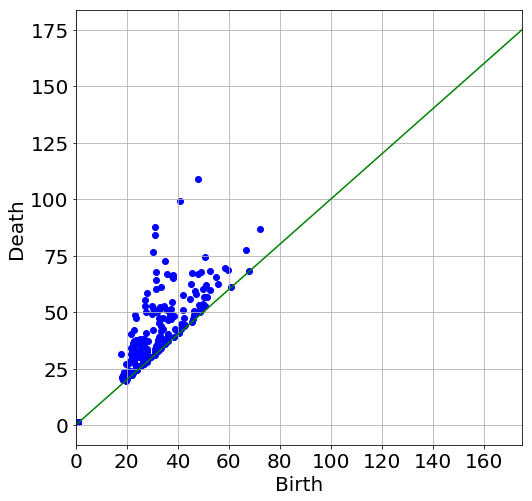

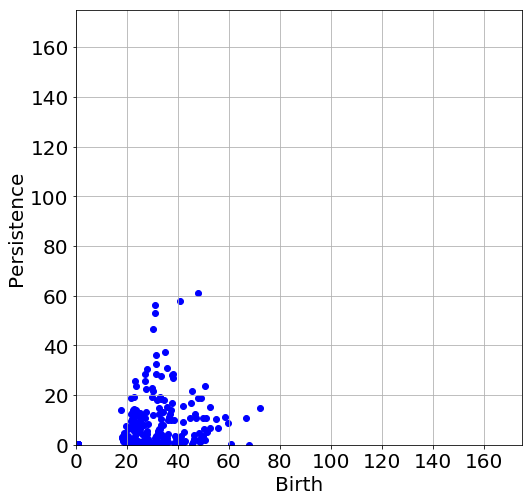

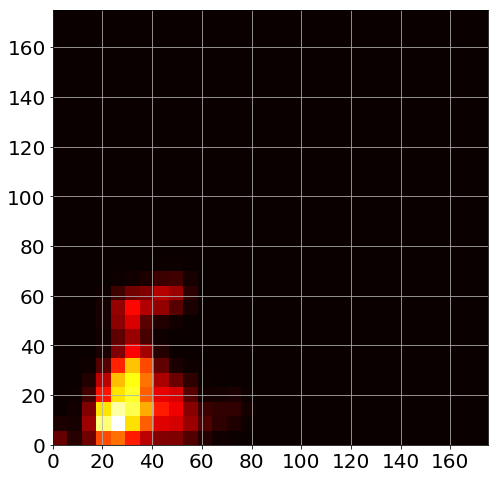

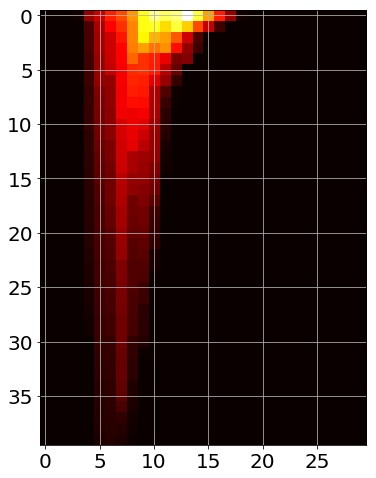

In [335]:
fname_list = [
    'train_22', # healthy case - axial
    'train_84', # healthy case - non-axial
    'train_11', # malignant - poorly differentiated case - axial
    'train_81'  # malignant - poorly differentiated - non-axial
]

resultsDir = '/home/deepak.chittajallu/emory/papers/2017-ISBI-CancerGradingPersistenceHomology/figures/'

max_scale = 175
pi_sigma_factor = 3
pi_num_samples = 30
pl_k = 40
pl_num_samples = 30

figsize=(8,8)
ticksize = 20
labelsize = 20

for fname in fname_list:
    
    # load image
    fpath = os.path.join(dataDir, fname + '.bmp')       
    im_input = skimage.io.imread(fpath)[:, :, :3]

    skimage.io.imsave(os.path.join(resultsDir, fname + '.png'), im_input)

    # gland overlay
    fpath_annot = os.path.join(dataDir, 'annot', fname + '_anno.bmp')
    im_input_annot = skimage.io.imread(fpath_annot)
    
    plt.figure(figsize=figsize)
    plt.imshow(skimage.segmentation.mark_boundaries(im_input, im_input_annot, 
                                                    outline_color=[1,1,0], color=[1,1,0], mode='thick'))
    plt.grid('off')
    plt.axis('off')
    plt.savefig(os.path.join(resultsDir, fname + '_gland_annot.png'), bbox_inches='tight')
    
    # detect nuclei
    nuclei_pts, nuclei_rad = detect_nuclei(im_input, display_result=False)

    plt.figure(figsize=figsize)
    plt.imshow(im_input)  
    plt.plot(nuclei_pts[:, 1], nuclei_pts[:, 0], 'g+', markersize=10, linewidth=4)
    plt.grid('off')
    plt.axis('off')
    plt.savefig(os.path.join(resultsDir, fname + '_nuclei.png'), bbox_inches='tight')

    # persistence diagram
    dgm_mph = np.asarray(tda_utils.ComputeDiagramMPH(nuclei_pts, 1))
    bd_pairs_mph = [dgm_mph[dgm_mph[:, 0] == i, 1:] for i in range(2)]

    plt.figure(figsize=figsize)
    tda_utils.plot_persistence_diagram(bd_pairs_mph[1], inf_val=175)
    plt.xlabel('Birth', fontsize=labelsize)
    plt.ylabel('Death', fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.savefig(os.path.join(resultsDir, fname + '_pd_bd.png'), bbox_inches='tight')

    plt.figure(figsize=figsize)
    tda_utils.plot_birth_persistence_diagram(bd_pairs_mph[1], inf_val=175)
    plt.xlabel('Birth', fontsize=labelsize)
    plt.ylabel('Persistence', fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.savefig(os.path.join(resultsDir, fname + '_pd_bp.png'), bbox_inches='tight')
    
    # persistence image
    sigma = pi_sigma_factor * max_scale / pi_num_samples
    im_pi_dim_1 = tda_utils.compute_persistence_image(bd_pairs_mph[1], 
                                                      pi_num_samples, max_scale, max_scale, sigma=sigma)
    
    plt.figure(figsize=figsize)
    plt.imshow(im_pi_dim_1, cmap=plt.cm.hot, origin='lower', extent=[0, max_scale, 0, max_scale])
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.savefig(os.path.join(resultsDir, fname + '_pi.png'), bbox_inches='tight')
    
    # persistence landscape
    scale_range = np.array([0, max_scale])
    lscape_dim_1, scale_seq = tda_utils.compute_persistence_landscape(dgm_mph, 1, 
                                                                      k=pl_k, samples=pl_num_samples, 
                                                                      scale_range=scale_range)    
    
    plt.figure(figsize=figsize)
    plt.imshow(lscape_dim_1, cmap=plt.cm.hot) 
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.savefig(os.path.join(resultsDir, fname + '_pl.png'), bbox_inches='tight')


### Build and validate grade prediction classifier using persistent homology representations

In [276]:
def compute_topological_features(fname, max_scale=175, 
                                 pi_num_samples=30, pi_sigma_factor=3, 
                                 pl_k=40, pl_num_samples=30,
                                 debug=False):
    
    total_time = time.time()
    
    # load image
    im_input = skimage.io.imread(fname)[:, :, :3]
    
    # detect nuclei
    nuclei_time = time.time()
    
    nuclei_pts, nuclei_rad = detect_nuclei(im_input, display_result=False)
    
    nuclei_time = time.time() - nuclei_time
    
    # compute persistence diagram
    dgm_time = time.time()
    
    dgm_mph = np.asarray(tda_utils.ComputeDiagramMPH(nuclei_pts, 1))
    bd_pairs_mph = [dgm_mph[dgm_mph[:, 0] == i, 1:] for i in range(2)]
    
    dgm_time = time.time() - dgm_time
    
    # compute persistence image
    pi_time = time.time()

    sigma = pi_sigma_factor * max_scale / pi_num_samples
    im_pi_dim_1 = tda_utils.compute_persistence_image(bd_pairs_mph[1], 
                                                      pi_num_samples, max_scale, max_scale, sigma=sigma)
    
    pi_time = time.time() - pi_time

    # compute persistence landscape
    pl_time = time.time()
    
    scale_range = np.array([0, max_scale])
    lscape_dim_1, scale_seq = tda_utils.compute_persistence_landscape(dgm_mph, 1, 
                                                                      k=pl_k, samples=pl_num_samples, 
                                                                      scale_range=scale_range)    
    
    pl_time = time.time() - pl_time

    # compute cell graph features
    cg_time = time.time()
    
    fdata_cg = cgf.compute_global_cell_graph_features(nuclei_pts)
    fdata_cg.columns = ['cell_graph.' + col for col in fdata_cg.columns]
    
    cg_time = time.time() - cg_time
    
    # create pandas dataframe
    fvec = np.hstack((im_pi_dim_1.ravel(), 
                      lscape_dim_1.ravel(),
                      np.asarray(fdata_cg).ravel()
                     )).reshape(1, -1)

    feature_list = []    
    feature_list += ['tda.pi.dim1.%d' % i for i in range(im_pi_dim_1.size)]
    feature_list += ['tda.pl.dim1.%d' % i for i in range(lscape_dim_1.size)]
    feature_list += ['cell_graph.' + col for col in fdata_cg.columns]
    
    fdata = pd.DataFrame(fvec, columns=feature_list)

    # Print debug info
    if debug:
        
        total_time = time.time() - total_time

        print '\tNuclei detection: %d nuclei, %.2f seconds' % (len(nuclei_rad), nuclei_time)
        print "\tPersistence diagram computation: Dim0 - %d points, Dim1 - %d points, %.2f seconds" % (
            bd_pairs_mph[0].shape[0], bd_pairs_mph[1].shape[0], dgm_time)
        print '\tPersistence image computation: %.2f seconds' % pi_time
        print '\tPersistence landscape computation: %.2f seconds' % pl_time
        print '\tCell graph feature computation: %.2f seconds' % cg_time
        print '\tTotal time: %.2f seconds' % total_time
    
    
    return fdata    

def compute_dataset_features(df, feature_func, **kwargs):
    
    tic = time.time()
    
    result = []

    for i in range(len(df)):

        fpath = os.path.join(dataDir, df.iloc[i]['name'] + '.bmp')

        result.append(
            dask.delayed(feature_func)(fpath)
        )

    result = dask.delayed(result).compute()
    
    fdata = pd.concat(result, ignore_index=True)
    
    print 'Feature computation for %d samples took %.2f seconds ' % (len(df), time.time() - tic)
    
    return fdata
    
def plot_scatter_by_class(X, y, pointsize=None, legendsize=None):
    
    label_list = np.unique(y)
    
    for label in label_list:        
        plt.scatter(X[y == label, 0], X[y == label, 1], s=pointsize)
        
    plt.legend(label_list, fontsize=legendsize)

In [277]:
t = compute_topological_features(os.path.join(dataDir, 'train_11.bmp'))

In [278]:
pi_params = {'max_scale': 175, 
             'pi_num_samples': 30, 'pi_sigma_factor': 3, 
             'pl_k': 40, 'pl_num_samples': 30}

fdata_train = compute_dataset_features(df_train, compute_topological_features, **pi_params)

Feature computation for 85 samples took 341.75 seconds 


In [279]:
fdata_test = compute_dataset_features(df_test, compute_topological_features, **pi_params)

Feature computation for 80 samples took 302.62 seconds 


In [317]:
X_train_all = np.asarray(fdata_train)
X_test_all = np.asarray(fdata_test)

X_train_pi = np.asarray(fdata_train[[col for col in fdata_train.columns if col.startswith('tda.pi')]])
X_test_pi = np.asarray(fdata_test[[col for col in fdata_train.columns if col.startswith('tda.pi')]])

X_train_pl = np.asarray(fdata_train[[col for col in fdata_train.columns if col.startswith('tda.pl')]])
X_test_pl = np.asarray(fdata_test[[col for col in fdata_train.columns if col.startswith('tda.pl')]])

X_train_ph = np.asarray(fdata_train[[col for col in fdata_train.columns if col.startswith('tda')]])
X_test_ph = np.asarray(fdata_test[[col for col in fdata_train.columns if col.startswith('tda')]])

X_train_cg = np.asarray(fdata_train[[col for col in fdata_train.columns if col.startswith('cell_graph')]])
X_test_cg = np.asarray(fdata_test[[col for col in fdata_train.columns if col.startswith('cell_graph')]])

y_train_diagnosis = np.asarray(df_train['diagnosis'])
y_train_bin_grade = np.asarray(df_train['binarized_grade'])
y_train_grade = np.asarray(df_train['grade'])

In [282]:
def visualize_features_2D(X, y):

    dim_red_methods = {
        'PCA': sklearn.decomposition.PCA(n_components=2),
        'TSNE': sklearn.manifold.TSNE(n_components=2),
        'MDS': sklearn.manifold.MDS(n_components=2),
        'ISOMAP':sklearn.manifold.Isomap(n_components=2),
        'SpectralEmbedding': sklearn.manifold.SpectralEmbedding(n_components=2),
        'LLE': sklearn.manifold.LocallyLinearEmbedding(n_components=2)
    }

    if len(np.unique(y)) > 2:
        dim_red_methods['LDA'] = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)    
    
    plt.figure(figsize=(6 * 4, 6 * (1 + len(dim_red_methods)%4)))
    
    i = 0
    for mname, mfunc in dim_red_methods.iteritems():

        plt.subplot(1 + len(dim_red_methods)%4, 4, i+1)  
        
        if 'LDA' in dim_red_methods:
            plot_scatter_by_class(mfunc.fit_transform(X, y), y)
        else:
            plot_scatter_by_class(mfunc.fit_transform(X), y)
            
        plt.title(mname)

        i += 1       
        
def gen_2d_feature_vis(X, y, method='PCA', pointsize=None, legendsize=None):
    
    dim_red_methods = {
        'PCA': sklearn.decomposition.PCA(n_components=2),
        'TSNE': sklearn.manifold.TSNE(n_components=2),
        'MDS': sklearn.manifold.MDS(n_components=2),
        'ISOMAP':sklearn.manifold.Isomap(n_components=2),
        'SE': sklearn.manifold.SpectralEmbedding(n_components=2),
        'LLE': sklearn.manifold.LocallyLinearEmbedding(n_components=2)
    }    
    
    mfunc = dim_red_methods[method]
    
    if 'LDA' in dim_red_methods:
        plot_scatter_by_class(mfunc.fit_transform(X, y), y, pointsize=pointsize, legendsize=legendsize)
    else:
        plot_scatter_by_class(mfunc.fit_transform(X), y, pointsize=pointsize, legendsize=legendsize)

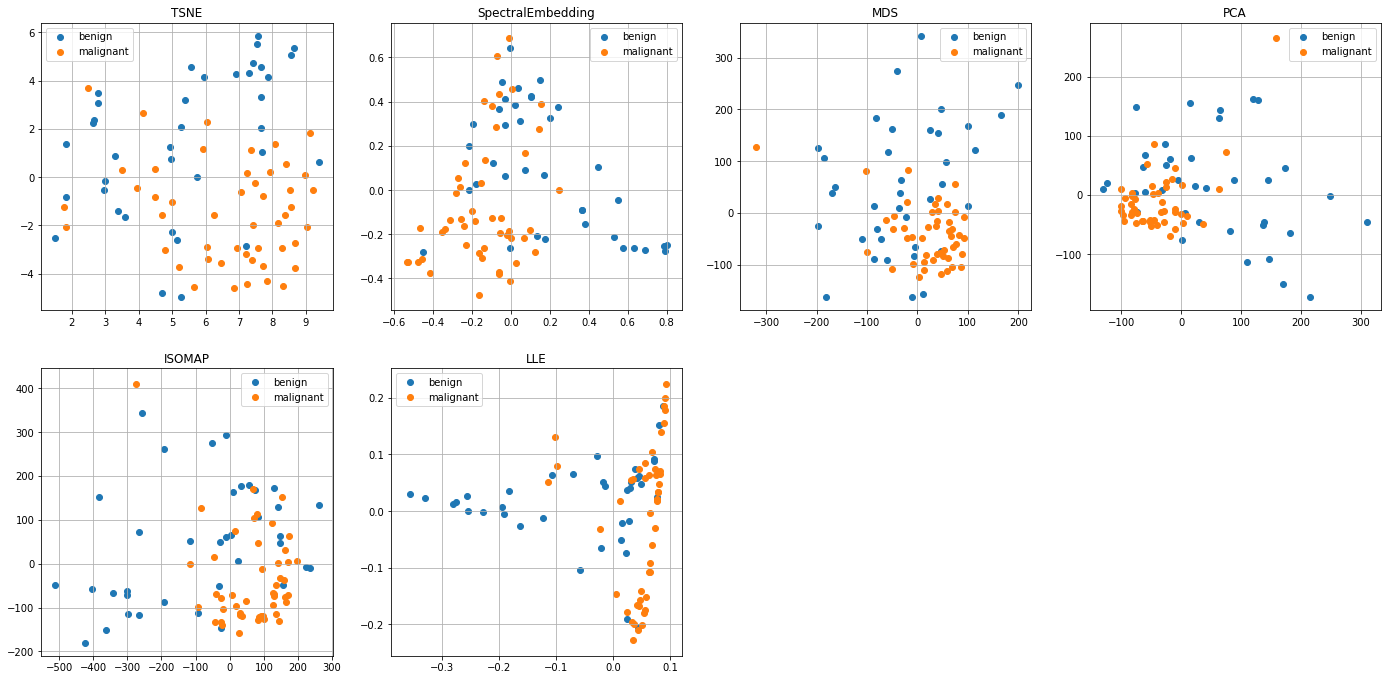

In [283]:
visualize_features_2D(X_train_pl, y_train_diagnosis)

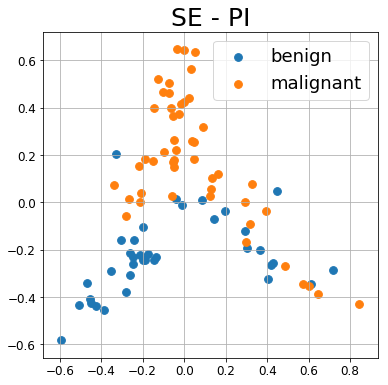

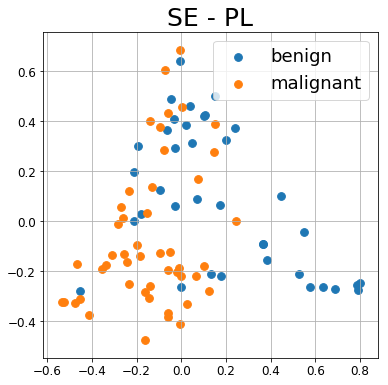

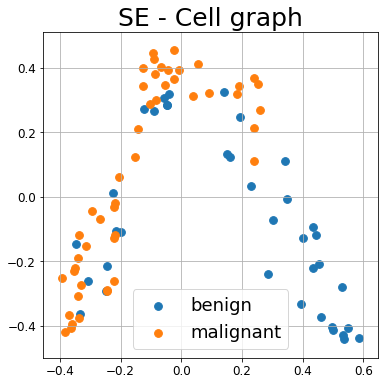

In [284]:
method = 'SE'

titlesize=25
legendsize=18
pointsize=60
ticksize=12

figsize=(6,6)

plt.figure(figsize=figsize)
gen_2d_feature_vis(X_train_pi, y_train_diagnosis, method, pointsize=pointsize, legendsize=legendsize)
plt.title(method + ' - PI', fontsize=titlesize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.savefig(os.path.join(resultsDir, 'pi_%s.png' % method), bbox_inches='tight')

plt.figure(figsize=figsize)
gen_2d_feature_vis(X_train_pl, y_train_diagnosis, method, pointsize=pointsize, legendsize=legendsize)
plt.title(method + ' - PL', fontsize=titlesize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.savefig(os.path.join(resultsDir, 'pl_%s.png' % method), bbox_inches='tight')

plt.figure(figsize=figsize)
gen_2d_feature_vis(X_train_cg, y_train_diagnosis, method, pointsize=pointsize, legendsize=legendsize)
plt.title(method + ' - Cell graph', fontsize=titlesize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.savefig(os.path.join(resultsDir, 'cg_%s.png' % method), bbox_inches='tight')

In [313]:
def dim_red_pca(X_train, X_test, var_cutoff=0.99, display_result=False):
    
    pca = sklearn.decomposition.PCA()
    pca.fit(X_train)

    var_percent = pca.explained_variance_ratio_.cumsum()
    num_features = np.sum(var_percent <= var_cutoff)
    print '%d features are needed to cover %d%% variance' % (num_features, var_cutoff * 100)
    
    if display_result:
        plt.figure(figsize=(6,6))
        plt.plot(var_percent)
        
    X_train_pca = pca.transform(X_train)[:, :num_features]
    X_test_pca = pca.transform(X_test)[:, :num_features]

    return X_train_pca, X_test_pca

In [327]:
X_train_cg_pca, X_test_cg_pca = dim_red_pca(X_train_cg, X_test_cg)
X_train_pi_pca, X_test_pi_pca = dim_red_pca(X_train_pi, X_test_pi)
X_train_pl_pca, X_test_pl_pca = dim_red_pca(X_train_pl, X_test_pl)
# X_train_ph_pca, X_test_ph_pca = dim_red_pca(X_train_ph, X_test_ph)
X_train_ph_pca = np.hstack((X_train_pi_pca, X_train_pl_pca))
X_test_ph_pca = np.hstack((X_test_pi_pca, X_test_pl_pca))

2 features are needed to cover 99% variance
54 features are needed to cover 99% variance
33 features are needed to cover 99% variance


In [287]:
def hyperopt_train_and_test_classifier(X_train, y_train, X_test, y_test, 
                                       max_evals=50, trial_timeout=120, pos_label=None, verbose=False):

    # Define search space
    
    estim = hpsklearn.HyperoptEstimator(classifier=hpsklearn.random_forest('my_clf', n_jobs=-1),
                                        preprocessing=[],
                                        algo=hyperopt.tpe.suggest,                                        
                                        verbose=verbose, 
                                        max_evals=max_evals, trial_timeout=trial_timeout)
    estim.fit(X_train, y_train)

    print estim.best_model()    
    
    print 'Accuracy: ', estim.score(X_test, y_test)
    
    y_test_pred = estim.predict(X_test)
    
    if pos_label is not None:        
        print 'AUC: ', sklearn.metrics.roc_auc_score(y_test == pos_label, 
                                                     y_test_pred == pos_label)
    
    print sklearn.metrics.classification_report(y_test, y_test_pred)
    
    return estim

def train_test_rf_classifier(X_train, y_train, X_test, y_test, 
                             n_estimators=100, n_trials=30, pos_label=None):
    
    rf_best = None
    
    for i in range(n_trials):
        
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, 
                                                     oob_score=True, class_weight="balanced", 
                                                     n_jobs=-1, random_state=i)
        rf.fit(X_train, y_train)   
        
        if i == 0 or rf.oob_score_ > rf_best.oob_score_:
            rf_best = rf
            
    y_test_pred = rf_best.predict(X_test)
    
    print 'Accuracy: ', np.mean(y_test == y_test_pred)
    
    if pos_label is not None:        
        assert(len(np.unique(y_train)) == 2)
        print 'AUC: ', sklearn.metrics.roc_auc_score(y_test == pos_label, 
                                                     y_test_pred == pos_label)
        
    print sklearn.metrics.classification_report(y_test, y_test_pred)    
    
    return rf_best

#### Evaluate cell graph features

In [270]:
hyperopt_train_and_test_classifier(X_train_cg, y_train_diagnosis, X_test_cg, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.008110 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.008634 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.058824
INFO:hyperopt.tpe:tpe_transform took 0.008542 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008797 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008425 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007339 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007791 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008526 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007822 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.329468599813,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=33, n_jobs=-1, oob_score=False, random_state=2,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.85
AUC:  0.845380263985
             precision    recall  f1-score   support

     benign       0.88      0.78      0.83        37
  malignant       0.83      0.91      0.87        43

avg / total       0.85      0.85      0.85        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb3e2c410>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [288]:
train_test_rf_classifier(X_train_cg, y_train_diagnosis, X_test_cg, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.9
AUC:  0.897548711502
             precision    recall  f1-score   support

     benign       0.91      0.86      0.89        37
  malignant       0.89      0.93      0.91        43

avg / total       0.90      0.90      0.90        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=5,
            verbose=0, warm_start=False)

In [319]:
hyperopt_train_and_test_classifier(X_train_cg_pca, y_train_diagnosis, X_test_cg_pca, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.008945 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.009372 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007365 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.008953 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007523 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007329 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.009068 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.058824
INFO:hyperopt.tpe:tpe_transform took 0.009087 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.058824
INFO:hyperopt.tpe:tpe_transform took 0.007350 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.738021051, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.8125
AUC:  0.806725329981
             precision    recall  f1-score   support

     benign       0.84      0.73      0.78        37
  malignant       0.79      0.88      0.84        43

avg / total       0.82      0.81      0.81        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb3c85b10>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [310]:
train_test_rf_classifier(X_train_cg_pca, y_train_diagnosis, X_test_cg_pca, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.8125
AUC:  0.818038969202
             precision    recall  f1-score   support

     benign       0.75      0.89      0.81        37
  malignant       0.89      0.74      0.81        43

avg / total       0.82      0.81      0.81        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=9,
            verbose=0, warm_start=False)

#### Evaluate persistence image features

In [256]:
hyperopt_train_and_test_classifier(X_train_pi, y_train_diagnosis, X_test_pi, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.009926 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.008319 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007540 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007398 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007386 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008234 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008011 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007226 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007261 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

INFO:hyperopt.tpe:TPE using 69/69 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007074 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007701 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006958 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008621 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008626 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.010047 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007804 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008657 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with be

INFO:hyperopt.tpe:tpe_transform took 0.007093 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007121 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.010757 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008147 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007407 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006981 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007647 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006982 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform 

INFO:hyperopt.tpe:tpe_transform took 0.007712 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007236 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007637 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007967 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006964 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007113 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007259 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009788 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform 

INFO:hyperopt.tpe:tpe_transform took 0.008223 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007281 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008303 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008278 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009551 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007070 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007622 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008104 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform 

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=3, max_features=0.404382478192,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=71, n_jobs=-1, oob_score=False, random_state=1,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.825
AUC:  0.829666876179
             precision    recall  f1-score   support

     benign       0.77      0.89      0.82        37
  malignant       0.89      0.77      0.82        43

avg / total       0.83      0.82      0.82        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=300,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb4f01bd0>,
          trial_timeout=300, use_partial_fit=False, verbose=False)

In [292]:
train_test_rf_classifier(X_train_pi, y_train_diagnosis, X_test_pi, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.85
AUC:  0.854808296669
             precision    recall  f1-score   support

     benign       0.79      0.92      0.85        37
  malignant       0.92      0.79      0.85        43

avg / total       0.86      0.85      0.85        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=29,
            verbose=0, warm_start=False)

In [320]:
hyperopt_train_and_test_classifier(X_train_pi_pca, y_train_diagnosis, X_test_pi_pca, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.008731 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.008513 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009319 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008338 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009229 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008614 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008356 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009134 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007123 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=2, max_features=0.519839693439, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=-1,
            oob_score=False, random_state=2, verbose=False,
            warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.85
AUC:  0.856693903206
             precision    recall  f1-score   support

     benign       0.78      0.95      0.85        37
  malignant       0.94      0.77      0.85        43

avg / total       0.87      0.85      0.85        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb3896a10>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [293]:
train_test_rf_classifier(X_train_pi_pca, y_train_diagnosis, X_test_pi_pca, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.8
AUC:  0.800754242615
             precision    recall  f1-score   support

     benign       0.77      0.81      0.79        37
  malignant       0.83      0.79      0.81        43

avg / total       0.80      0.80      0.80        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=12,
            verbose=0, warm_start=False)

#### Evaluate persistence landscape features

In [271]:
hyperopt_train_and_test_classifier(X_train_pl, y_train_diagnosis, X_test_pl, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.006877 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.010389 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007424 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008667 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007575 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.010091 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008736 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009496 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007656 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
            oob_score=False, random_state=4, verbose=False,
            warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.8875
AUC:  0.885920804525
             precision    recall  f1-score   support

     benign       0.89      0.86      0.88        37
  malignant       0.89      0.91      0.90        43

avg / total       0.89      0.89      0.89        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb5906a10>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [294]:
train_test_rf_classifier(X_train_pl, y_train_diagnosis, X_test_pl, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.8625
AUC:  0.866436203646
             precision    recall  f1-score   support

     benign       0.81      0.92      0.86        37
  malignant       0.92      0.81      0.86        43

avg / total       0.87      0.86      0.86        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=23,
            verbose=0, warm_start=False)

In [329]:
hyperopt_train_and_test_classifier(X_train_pl_pca, y_train_diagnosis, X_test_pl_pca, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.009159 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.007991 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.176471
INFO:hyperopt.tpe:tpe_transform took 0.007139 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.176471
INFO:hyperopt.tpe:tpe_transform took 0.006786 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.008794 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.008691 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007429 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007890 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.117647
INFO:hyperopt.tpe:tpe_transform took 0.007708 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=660, n_jobs=-1,
            oob_score=False, random_state=2, verbose=False,
            warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.8375
AUC:  0.843180389692
             precision    recall  f1-score   support

     benign       0.77      0.92      0.84        37
  malignant       0.92      0.77      0.84        43

avg / total       0.85      0.84      0.84        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb3337f10>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [325]:
train_test_rf_classifier(X_train_pl_pca, y_train_diagnosis, X_test_pl_pca, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.775
AUC:  0.777498428661
             precision    recall  f1-score   support

     benign       0.73      0.81      0.77        37
  malignant       0.82      0.74      0.78        43

avg / total       0.78      0.78      0.78        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=25,
            verbose=0, warm_start=False)

#### Evaluate all persistent homology features

In [273]:
hyperopt_train_and_test_classifier(X_train_ph, y_train_diagnosis, X_test_ph, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.008739 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.007470 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.058824
INFO:hyperopt.tpe:tpe_transform took 0.007479 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.058824
INFO:hyperopt.tpe:tpe_transform took 0.008265 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009951 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009555 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.010454 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.010240 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.009439 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=3, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2514, n_jobs=-1, oob_score=False, random_state=4,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.9
AUC:  0.903205531113
             precision    recall  f1-score   support

     benign       0.85      0.95      0.90        37
  malignant       0.95      0.86      0.90        43

avg / total       0.90      0.90      0.90        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5eb434e310>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [296]:
train_test_rf_classifier(X_train_ph, y_train_diagnosis, X_test_ph, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.9125
AUC:  0.914833438089
             precision    recall  f1-score   support

     benign       0.88      0.95      0.91        37
  malignant       0.95      0.88      0.92        43

avg / total       0.92      0.91      0.91        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=23,
            verbose=0, warm_start=False)

In [330]:
hyperopt_train_and_test_classifier(X_train_ph_pca, y_train_diagnosis, X_test_ph_pca, y_test_diagnosis, 
                                   pos_label='malignant')

INFO:hyperopt.tpe:tpe_transform took 0.007813 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.007125 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007935 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.007231 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008878 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008665 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006868 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.008009 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000000
INFO:hyperopt.tpe:tpe_transform took 0.006955 seconds
INFO:hyperopt.tpe:TPE using 8/8 tria

{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.33319394811,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=135, n_jobs=-1, oob_score=False, random_state=1,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
Accuracy:  0.85
AUC:  0.856693903206
             precision    recall  f1-score   support

     benign       0.78      0.95      0.85        37
  malignant       0.94      0.77      0.85        43

avg / total       0.87      0.85      0.85        80



hyperopt_estimator(algo=<function suggest at 0x7f5ea5e9b758>, classifier=None,
          ex_preprocs=None, fit_increment=1,
          fit_increment_dump_filename=None, loss_fn=None, max_evals=50,
          preprocessing=None, regressor=None, seed=None,
          space=<hyperopt.pyll.base.Apply object at 0x7f5e45462fd0>,
          trial_timeout=120, use_partial_fit=False, verbose=False)

In [297]:
train_test_rf_classifier(X_train_ph_pca, y_train_diagnosis, X_test_ph_pca, y_test_diagnosis, pos_label='malignant')

Accuracy:  0.775
AUC:  0.777498428661
             precision    recall  f1-score   support

     benign       0.73      0.81      0.77        37
  malignant       0.82      0.74      0.78        43

avg / total       0.78      0.78      0.78        80



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=25,
            verbose=0, warm_start=False)

### Grade prediction classifier using cell/gland graph features

Reference: 

* Doyle, S., Agner, S., Madabhushi, A., Feldman, M., & Tomaszewski, J. "Automated grading of breast cancer histopathology using spectral clustering with textural and architectural image features". 5th IEEE International Symposium on In Biomedical Imaging: From Nano to Macro, 2008. (pp. 496-499)

* Doyle S, Hwang M, Shah K, Madabhushi A, Feldman M, Tomaszeweski J. Automated grading of prostate cancer using architectural and textural image features. In 4th IEEE international symposium on Biomedical imaging: from nano to macro, 2007. Apr 12 (pp. 1284-1287).